In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm

In [40]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)
matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (4.01407, 3.09654)

In [33]:
oog = OG.BasicOpticalGating().default()
#oog.sequence_manager.set_source(r"D:\Data\both 800fps\brightfield\*tif")
#oog.settings["include_reference_frames"] = False
oog.run()

Setting source to D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield\*tif
Loading reference sequence from D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\ref_seq.tif


Getting phases: 100%|██████████| 1106/1106 [00:00<00:00, 57918.20it/s]


In [4]:
print(oog.settings)

{'drift_correction': True, 'padding_frames': 2, 'normalise_sad': False, 'pi_space': True, 'buffer_length': 800, 'reference_framerate_reduction': 1, 'include_reference_frames': True, 'subframe_method': 'v_fitting'}


In [34]:
# Gets the noise spectrum by looking at the standard deviation of the change in delta phases over some time period.
def get_noise_spectrum(delta_phases, averaging_window):
    time_windows = range(1, (delta_phases.shape[0] - averaging_window) // 2, 1)
    avg_delta_phases_std = []
    for time_window in tqdm(time_windows):
        avg_delta_phases = []
        for i in np.arange(delta_phases.shape[0] - time_window - averaging_window):
            average_delta_phase_init = np.mean(delta_phases[i:i + averaging_window])
            average_delta_phase_final = np.mean(delta_phases[i + time_window:i + time_window + averaging_window])

            est_avg_delta_phases = average_delta_phase_init - average_delta_phase_final

            avg_delta_phases.append(est_avg_delta_phases)

        avg_delta_phases_std.append(np.std(avg_delta_phases))

    return time_windows, avg_delta_phases_std

In [35]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(OG.radsperframe_to_bps(np.array(gradients),80))


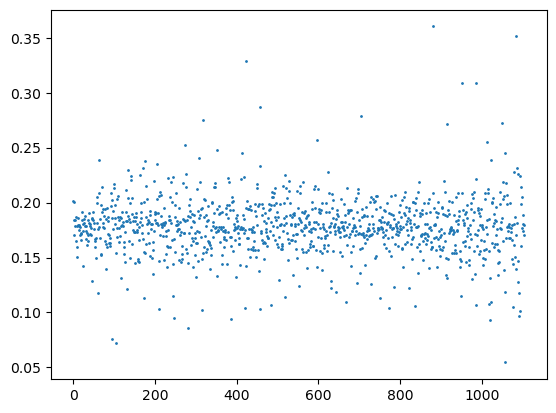

In [36]:
plt.scatter(range(len(oog.delta_phases)), oog.delta_phases, s = 1)
plt.show()

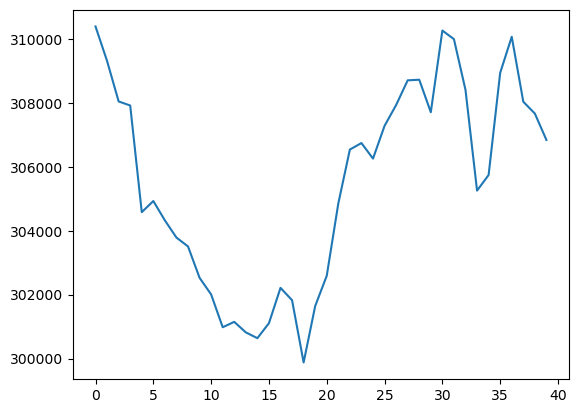

In [37]:
plt.plot(np.sum(np.abs(np.diff(oog.sequence_manager.reference_sequence.astype(np.int32))), axis = (1,2)))

In [46]:
plt.figure()
plt.scatter(oog.phases[1::], oog.delta_phases, s = 2)
plt.xlabel("Phase (rads)")
plt.ylabel("Phase velocity (rads/frame)")
plt.tight_layout()
plt.savefig("delta_phases.pgf")

In [39]:
# Get moving average of delta phases using a window of 10 frames and np.convolve
averaging_window = oog.sequence_manager.reference_sequence.shape[0]
moving_avg = np.convolve(oog.delta_phases, np.ones(averaging_window) / averaging_window, mode='valid')

In [43]:
plt.figure()
plt.scatter(range(len(moving_avg)), moving_avg, s = 1)
plt.xlabel("Frame")
plt.ylabel("Moving average of phase velocity (rads/frame)")

Text(10.206666666666672, 0.5, 'Phase velocity (rads/frame)')

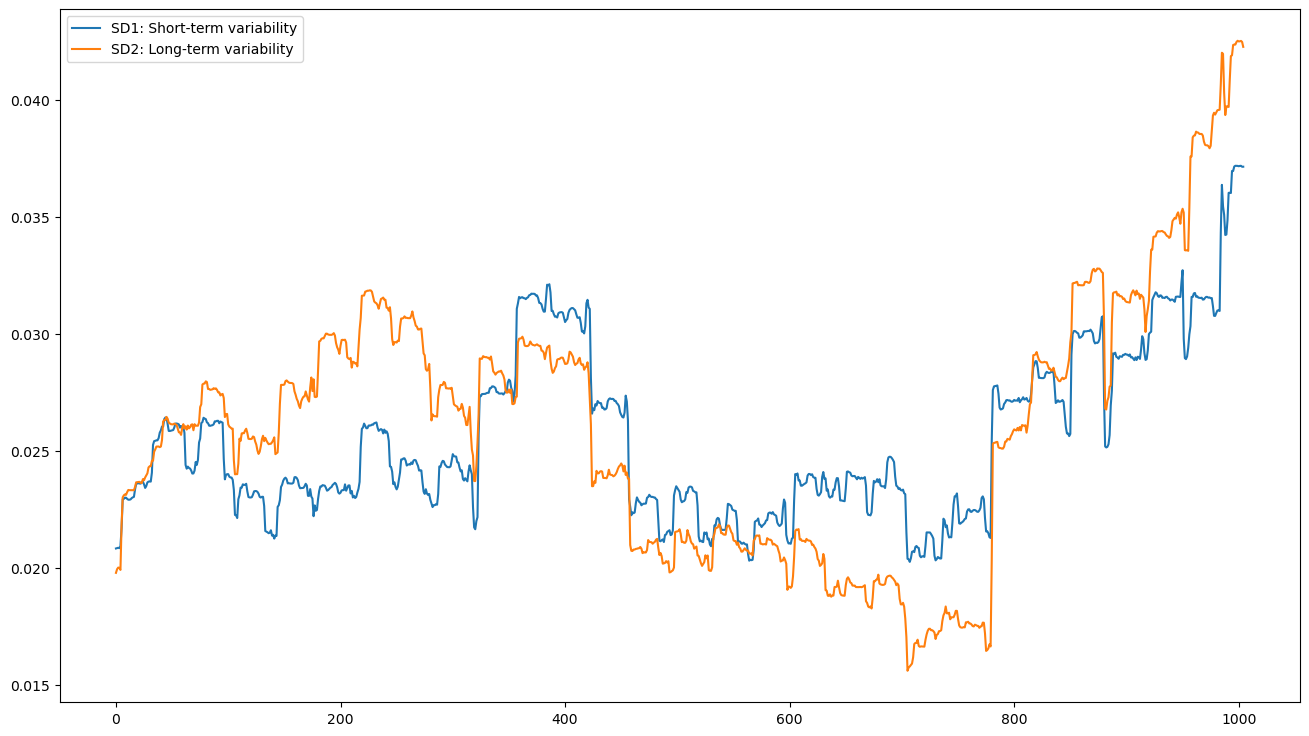

In [12]:
window = 100
sd1s = []
sd2s = []
for i in range(0, oog.delta_phases.shape[0] - window, 1):
    RR_1 = oog.delta_phases[i:i + window]
    RR_2 = oog.delta_phases[i + 1:i + window + 1]

    x_1 = (RR_1 - RR_2) / 2**(0.5)
    x_2 = (RR_1 + RR_2) / 2**(0.5)

    sd1 = np.sqrt(np.var(x_1))
    sd2 = np.sqrt(np.var(x_2))

    sd1s.append(sd1)
    sd2s.append(sd2)

plt.figure(figsize = (16,9))
plt.plot(sd1s, label = "SD1: Short-term variability")
plt.plot(sd2s, label = "SD2: Long-term variability")
plt.legend()
plt.show()

In [54]:
plt.figure()
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], c = range(len(oog.delta_phases) - 1), s = 2)
plt.colorbar(label = "Frame")
plt.xlabel("Phase velocity (rads/frame) at frame n")
plt.ylabel("Phase velocity (rads/frame) at frame n+1")
plt.tight_layout()
plt.savefig("Poincare_plot_lf.pgf")

In [56]:
plt.figure()
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], c = oog.phases[2::], s = 2)
plt.colorbar(label = "Phase (rads)")
plt.xlabel("Phase velocity (rads/frame) at frame n")
plt.ylabel("Phase velocity (rads/frame) at frame n+1")
plt.tight_layout()
plt.savefig("Poincare_plot_lf_phases.pgf")

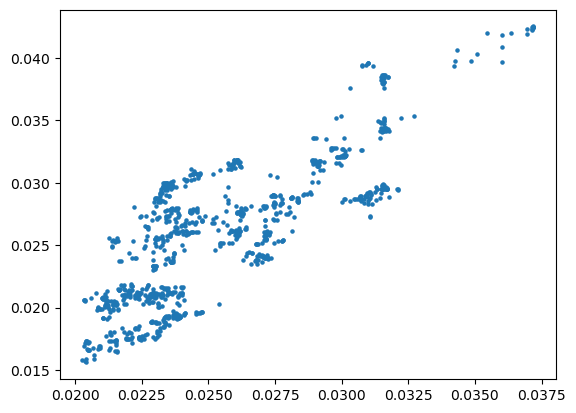

In [14]:
plt.scatter(sd1s, sd2s, s = 5)
plt.show()

In [15]:
RR_1 = gradients[1::]
RR_2 = gradients[0:-1]

x_1 = (RR_1 - RR_2) / 2**(0.5)
x_2 = (RR_1 + RR_2) / 2**(0.5)

sd1 = np.sqrt(np.var(x_1))
print(sd1)
sd2 = np.sqrt(np.var(x_2))
print(sd2)

0.012576379547062234
0.02362113705917552


In [53]:
plt.figure(figsize = (9,9))
plt.scatter(OG.radsperframe_to_bps(oog.delta_phases[1::], 80), OG.radsperframe_to_bps(oog.delta_phases[0:-1], 80), s = 5, c = range(len(oog.delta_phases) - 1))
plt.axis("equal")
plt.show()

plt.figure()
plt.plot(gradients[1::], gradients[0:-1], lw = 1, ls = ":")
plt.scatter(gradients[1::], gradients[0:-1], s = 5)
plt.axis("equal")
plt.xlabel("Beats per second at frame n")
plt.ylabel("Beats per second at frame n+1")
plt.axis("equal")
plt.tight_layout()
plt.savefig("poincare_plot_bps_80.pgf")

C:\Users\kross\AppData\Local\Temp\ipykernel_4588\2083872566.py:4: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


100%|██████████| 546/546 [00:16<00:00, 33.75it/s]


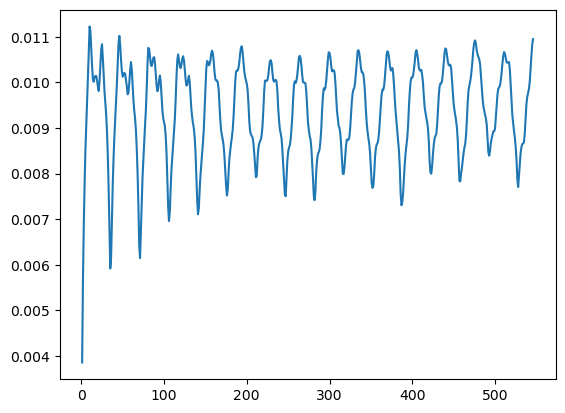

100%|██████████| 12/12 [00:00<00:00, 767.41it/s]


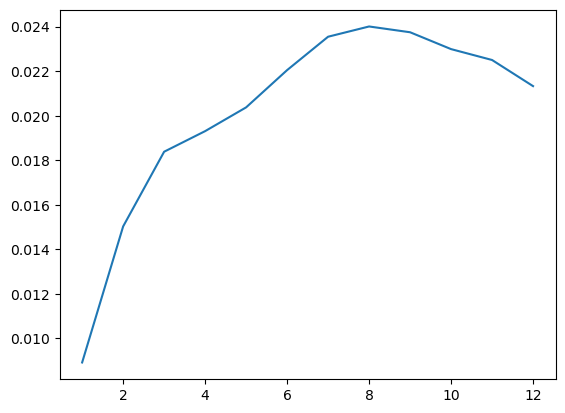

In [17]:
plt.plot(*get_noise_spectrum(oog.delta_phases, 10))
plt.show()
plt.plot(*get_noise_spectrum(gradients, 3))
plt.show()

In [18]:
oog = OG.BasicOpticalGating().default()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif")
oog.sequence_manager.reference_period = 73.106274
oog.run()

Setting source to D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\brightfield\*tif
Loading reference sequence from D:\Data\2012-06-20 13.34.11 vid 2x2 multi phase single plane\ref_seq.tif
Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif


Getting phases: 100%|██████████| 37970/37970 [00:00<00:00, 63976.70it/s]


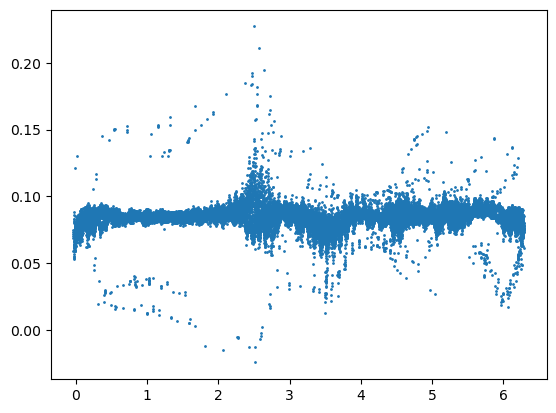

In [19]:
plt.scatter(oog.phases[1::], oog.delta_phases, s = 1)

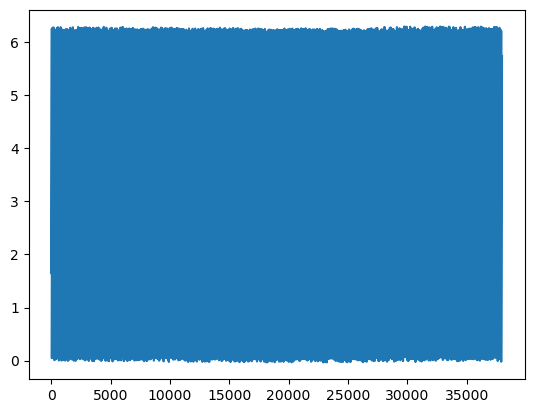

In [20]:
plt.plot(oog.phases)

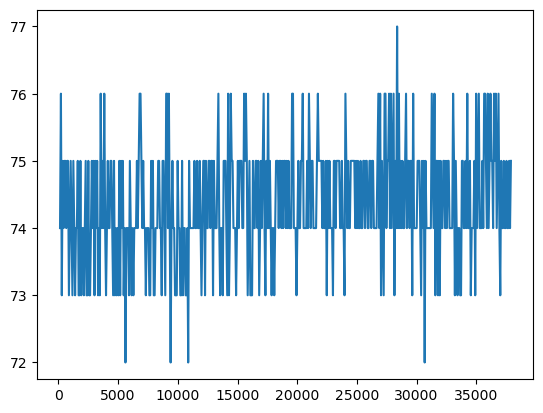

[57, 131, 207, 280, 355, 429, 504, 579, 653, 728, 803, 876, 950, 1025, 1099, 1172, 1247, 1321, 1394, 1468, 1542, 1617, 1690, 1763, 1838, 1911, 1985, 2059, 2132, 2206, 2281, 2354, 2427, 2502, 2575, 2648, 2722, 2797, 2871, 2946, 3019, 3094, 3168, 3243, 3316, 3390, 3463, 3539, 3613, 3688, 3762, 3838, 3912, 3985, 4059, 4134, 4208, 4282, 4357, 4432, 4506, 4579, 4654, 4727, 4801, 4874, 4948, 5021, 5096, 5169, 5244, 5318, 5393, 5466, 5540, 5612, 5686, 5760, 5834, 5907, 5982, 6056, 6129, 6203, 6276, 6350, 6424, 6498, 6573, 6647, 6722, 6798, 6874, 6949, 7023, 7098, 7172, 7246, 7319, 7393, 7467, 7541, 7614, 7687, 7762, 7836, 7911, 7984, 8057, 8131, 8205, 8279, 8354, 8429, 8503, 8577, 8650, 8725, 8800, 8874, 8947, 9023, 9099, 9173, 9249, 9323, 9395, 9469, 9544, 9618, 9692, 9765, 9838, 9911, 9986, 10060, 10134, 10207, 10280, 10355, 10428, 10502, 10576, 10649, 10722, 10796, 10868, 10943, 11017, 11091, 11165, 11239, 11313, 11388, 11462, 11536, 11611, 11685, 11759, 11834, 11908, 11981, 12055, 12130, 

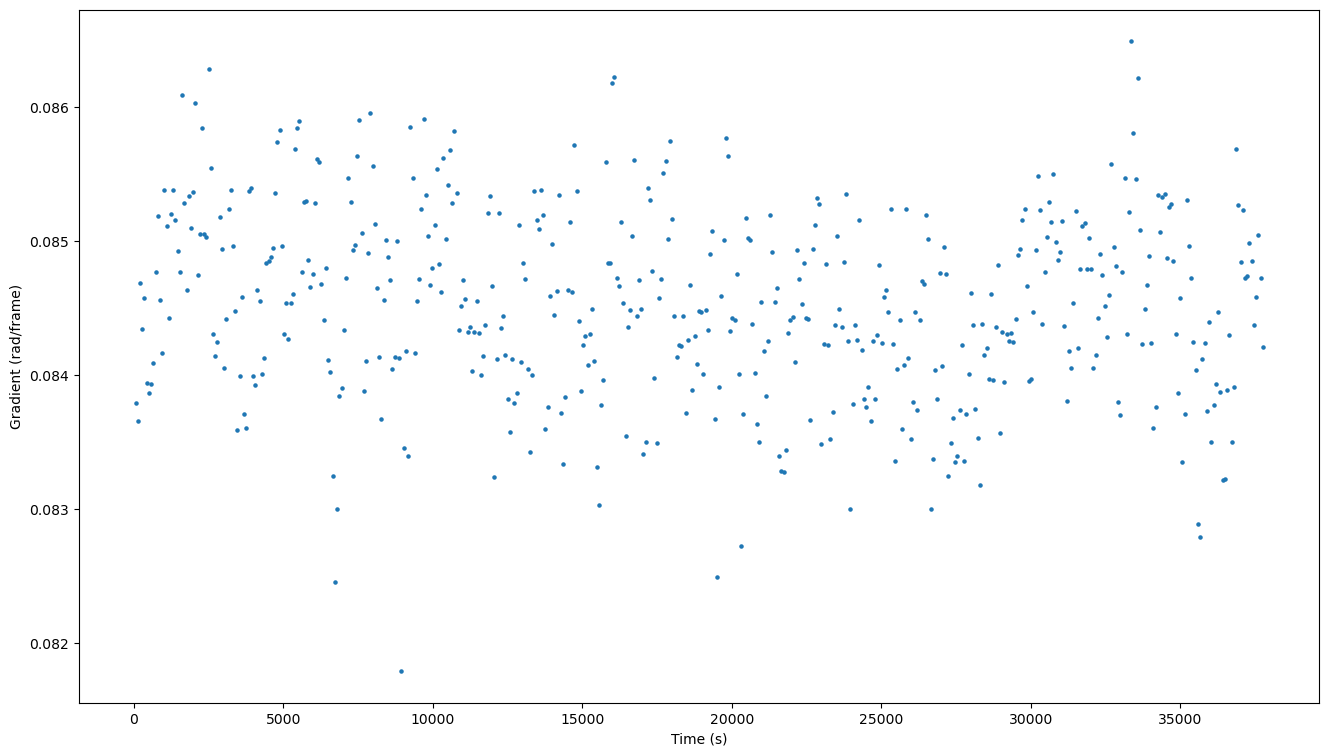

In [21]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

plt.plot(beat_indices[1::], np.diff(beat_indices))
plt.show()

print(beat_indices)
gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(gradients)

plt.figure(figsize = (16,9))
plt.scatter(np.array(beat_indices[:-2]), gradients, s = 5)
#plt.ylim(0.006, 0.011)
plt.xlabel("Time (s)")
plt.ylabel("Gradient (rad/frame)")
plt.show()

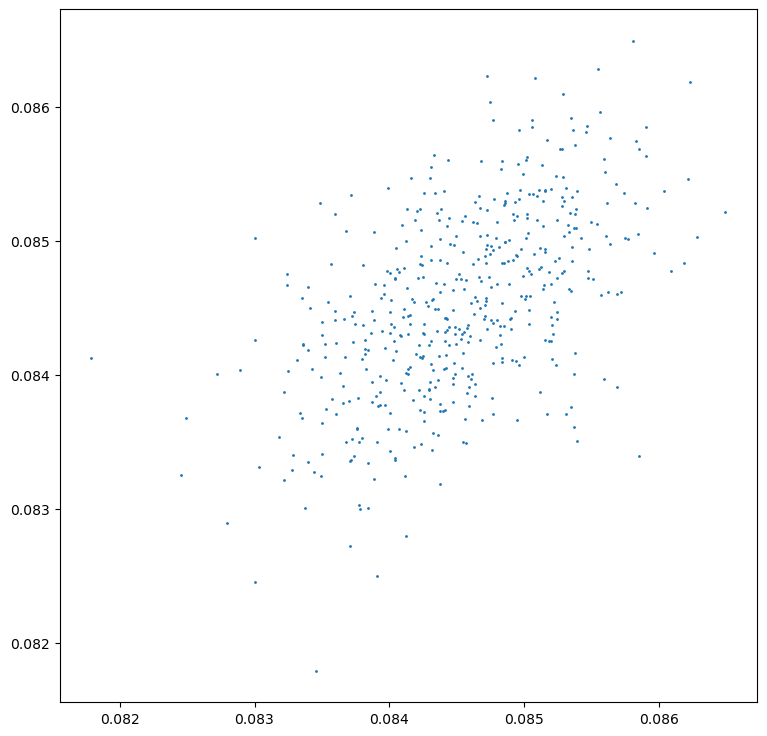

In [32]:
plt.figure(figsize = (9,9))
plt.scatter(gradients[1::], gradients[:-1], s = 1)

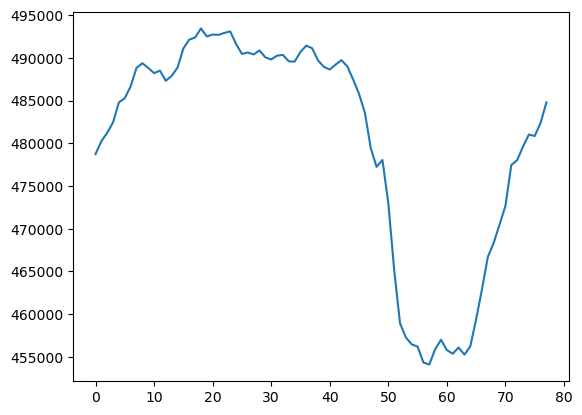

In [23]:
plt.plot(np.sum(np.abs(np.diff(oog.sequence_manager.reference_sequence.astype(np.int32))), axis = (1,2)))

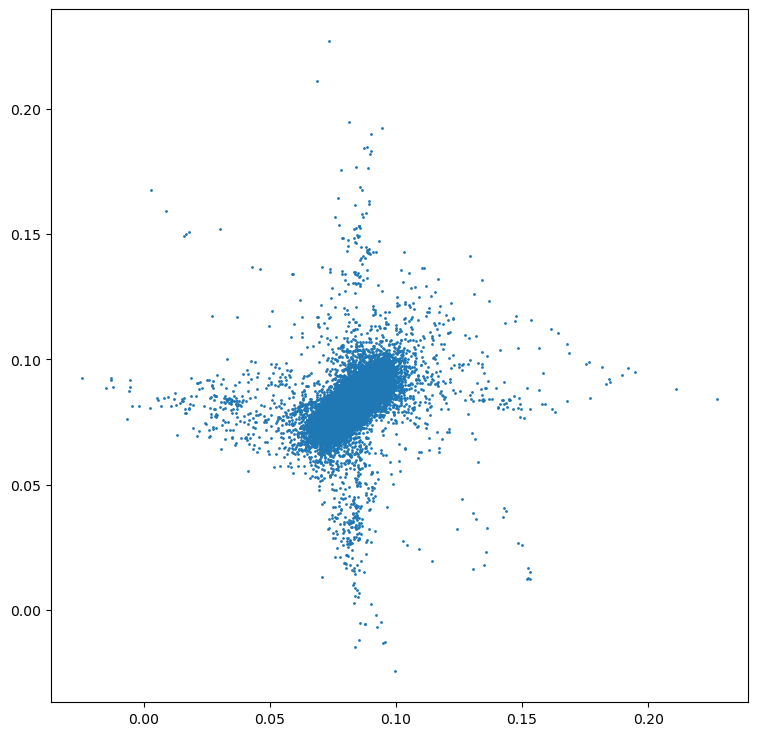

In [24]:
plt.figure(figsize = (9,9))
plt.scatter(oog.delta_phases[1::], oog.delta_phases[:-1], s = 1)

100%|██████████| 251/251 [00:03<00:00, 69.72it/s]


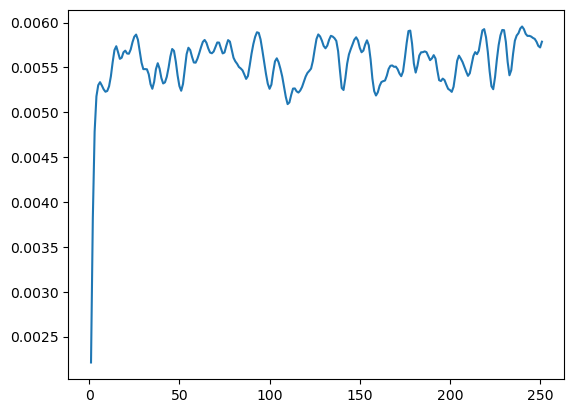

In [31]:
plt.plot(*get_noise_spectrum(1/OG.radsperframe_to_bps(gradients, 120), 3))

In [26]:
print(oog.delta_phases.shape)

(37969,)


In [27]:
ns = get_noise_spectrum(oog.delta_phases[0:10000], 100)

  0%|          | 0/4949 [00:00<?, ?it/s]

100%|██████████| 4949/4949 [22:21<00:00,  3.69it/s]


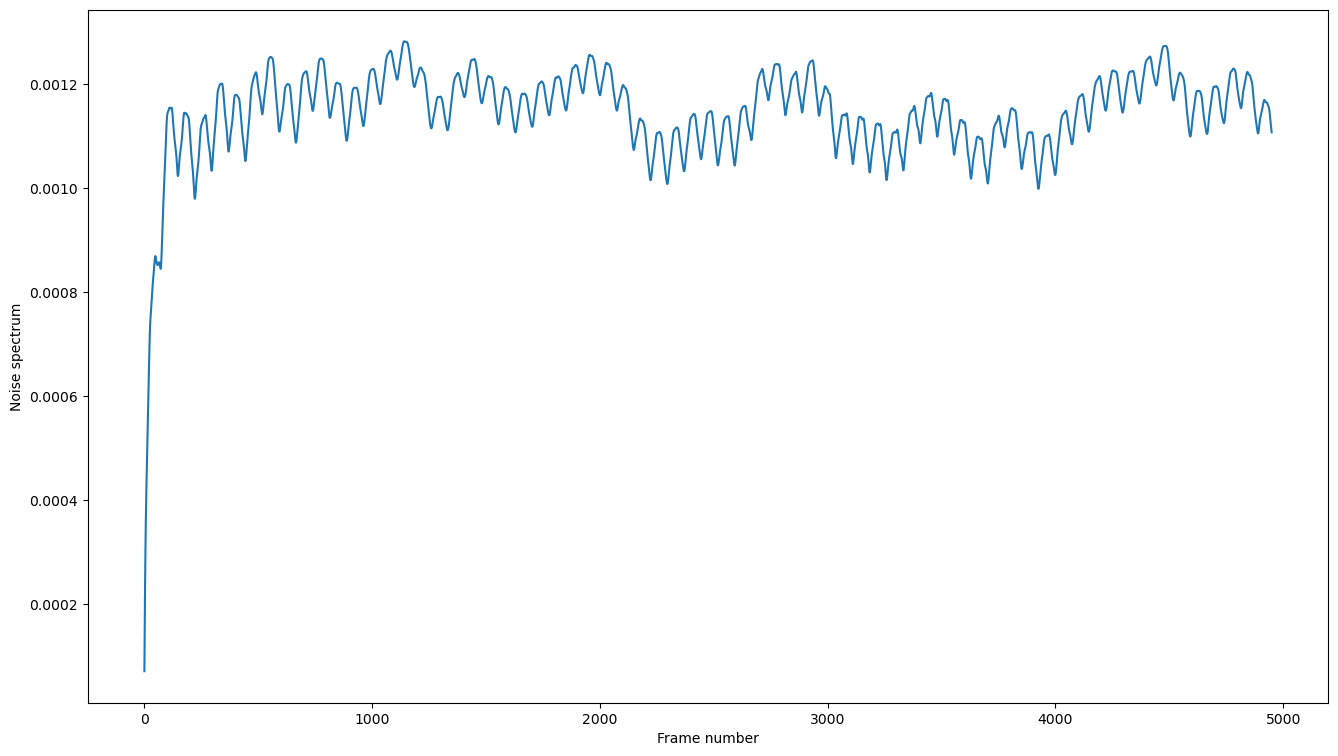

In [28]:
plt.figure(figsize = (16,9))
plt.plot(*ns)
plt.xlabel("Frame number")
plt.ylabel("Noise spectrum")
plt.show()